In [282]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
# set matplotlib backend to inline
%matplotlib inline

# import modules
from sklearn import datasets
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


In [283]:
from sklearn.preprocessing import StandardScaler

raw_nhl_data = pd.read_csv('moneypack/all_teams.csv')
columns_to_drop_from_total = ['name', 'gameId', 'playerTeam', 'opposingTeam', 'home_or_away', 'gameDate', 'position',
                              'situation', 'iceTime']
raw_nhl_data = raw_nhl_data.drop(columns=columns_to_drop_from_total)
raw_nhl_data = raw_nhl_data[(raw_nhl_data['season'] != '2023')]

raw_nhl_data_2023 = pd.read_csv('moneypack/all_teams_2023.csv')
raw_nhl_data_2023['playoffGame'] = [0] * len(raw_nhl_data_2023.index)
columns_to_drop_from_2023 = ['games_played', 'name', 'position', 'situation', 'team.1', 'iceTime']
raw_nhl_data_2023 = raw_nhl_data_2023.drop(columns=columns_to_drop_from_2023)

columns_all = raw_nhl_data.columns
columns_2023 = raw_nhl_data_2023.columns

# print(len(raw_nhl_data.columns))
# print(len(raw_nhl_data_2023.columns))

# print(columns_all.difference(columns_2023))
# print(columns_2023.difference(columns_all))

# print(len(raw_nhl_data.values))
# print(len(raw_nhl_data_2023.values))

# print(raw_nhl_data.values)
# print(raw_nhl_data_2023['playoffGame'].values)


by_team_season_all = raw_nhl_data.groupby(['team', 'season']).mean()
by_team_season_all['playoff_qualified'] = by_team_season_all['playoffGame'].apply(lambda val: 1 if val > 0.0 else 0)
#print(by_team_season_all)
# print(type(by_team_season_all))

X = by_team_season_all.drop(columns=['playoff_qualified', 'playoffGame'])
y = by_team_season_all['playoff_qualified']

# Standardize the numerical features using StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# print(pd.DataFrame(X_train_scaled, columns=X.columns).head())


In [284]:
corr_matrix = X.corr().abs()

# Plot the heatmap
plt.figure(figsize=(100, 100))
sns.heatmap(corr_matrix, annot=True, cmap='GnBu', linewidths=0.2, vmin=0, vmax=1)
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Feature Importances using Correlation Matrix Heatmap')
plt.show()

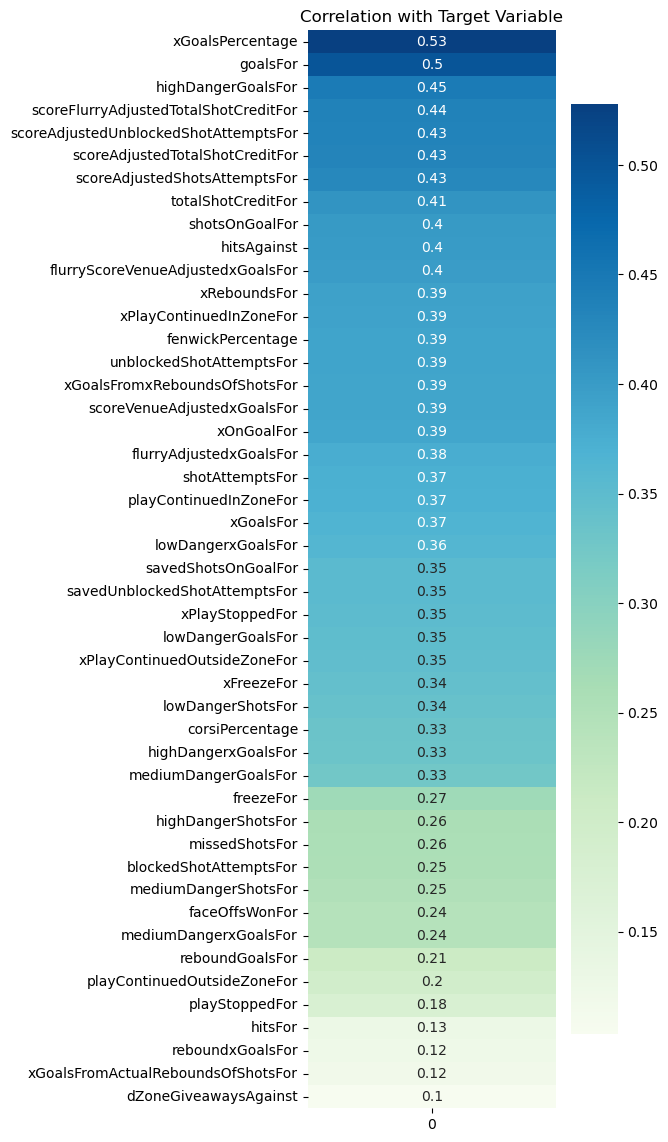

In [285]:

corr_with_target = X.corrwith(y)
corr_with_target = corr_with_target.sort_values(ascending=False)
corr_with_target.reset_index(name='score')

# selected_corr_with_target = pd.DataFrame(corr_with_target, columns=['score'])
# selected_corr_with_target.columns = ["feature", "score"]

corr_with_target = corr_with_target.loc[lambda x: x > 0.1]
# print(corr_with_target.index)
# Plot the heatmap
plt.figure(figsize=(4, 14))
sns.heatmap(corr_with_target.to_frame(), cmap='GnBu', annot=True)
plt.title('Correlation with Target Variable')
# plt.show()

corr_with_target_frame = pd.DataFrame({"feature": corr_with_target.index, "score": corr_with_target.values})


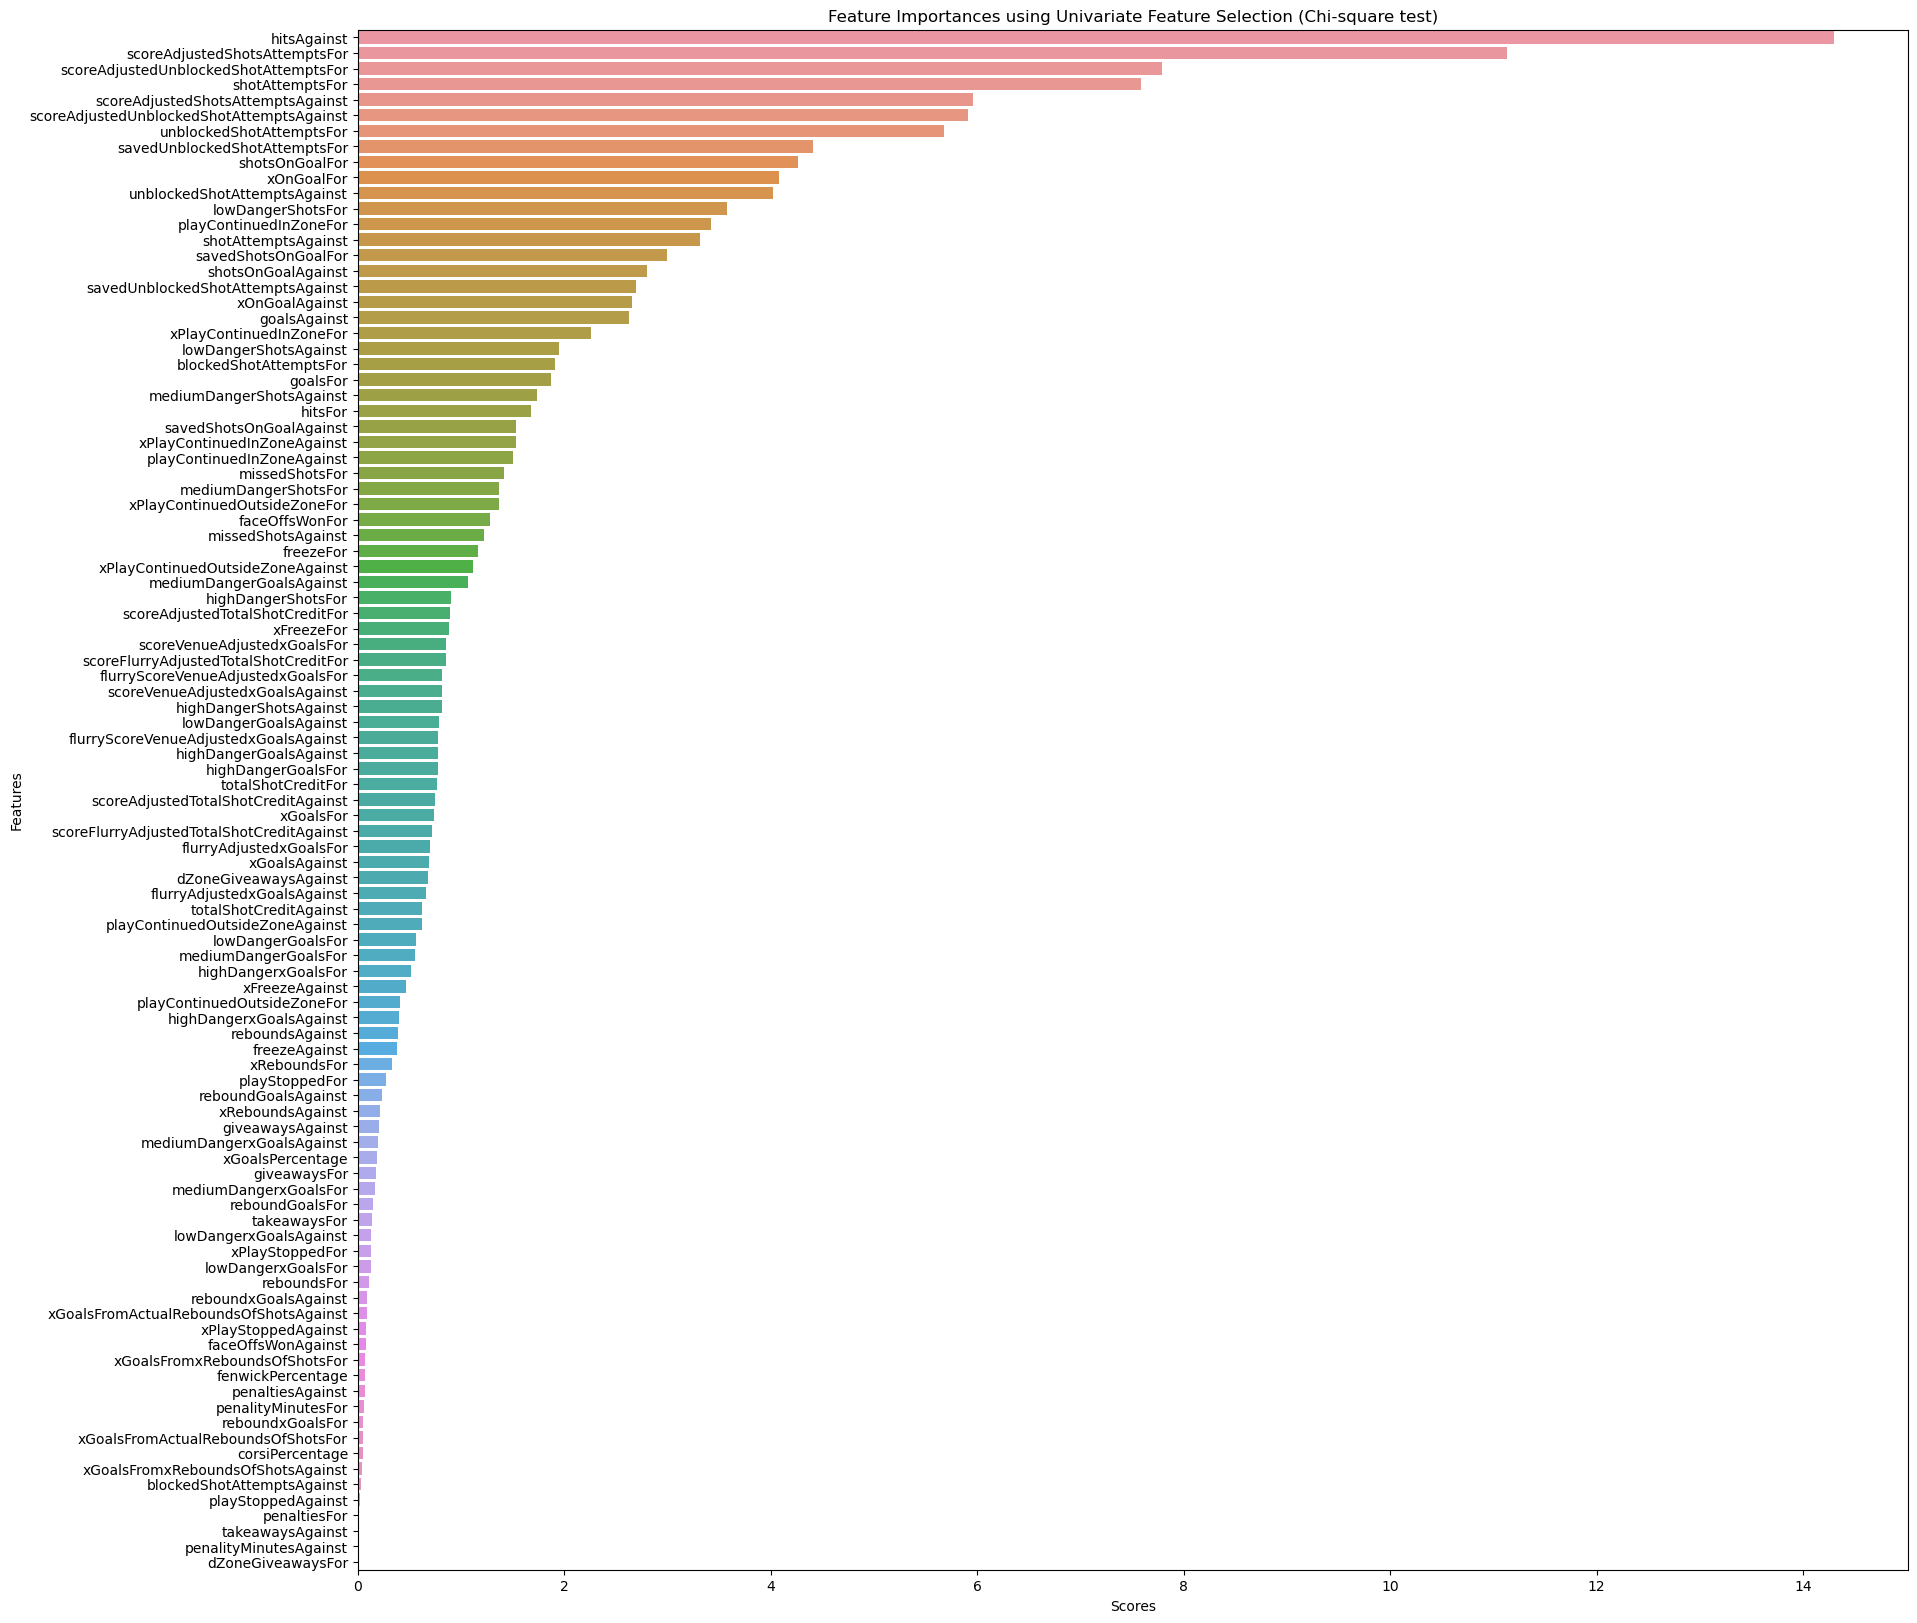

In [286]:
from sklearn.feature_selection import SelectKBest, chi2

# apply univariate feature selection
best_features = SelectKBest(score_func=chi2, k=5).fit(X, y)

# get the scores and selected features
scores = best_features.scores_
selected_features = X.columns[best_features.get_support()]

sorted_idxs = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_idxs]
sorted_feature_names = np.array(X.columns)[sorted_idxs]

sorted_features_with_scores = pd.DataFrame({"feature": sorted_feature_names, "score": sorted_scores})
sorted_features_with_scores = sorted_features_with_scores[sorted_features_with_scores['score'] > 1.0]
# print(sorted_features_with_scores)

# plot scores
plt.figure(figsize=(20, 20))
sns.barplot(x=sorted_scores, y=sorted_feature_names)
plt.xlabel('Scores')
plt.ylabel('Features')
plt.title('Feature Importances using Univariate Feature Selection (Chi-square test)')
plt.show()

In [287]:
# selected_important_features_data = pd.merge(sorted_features_with_scores, corr_with_target_frame, how ='left', on =['feature'])
selected_important_features_data = sorted_features_with_scores
important_features = selected_important_features_data["feature"].values

In [288]:
class MyKNearestNeighborsClassifier:
    pass

    def __init__(self, k):
        self.k = self.__validate_k(k)
        self.x_train = None
        self.y_train = None

    def fit(self, x_train, y_train):
        # np.unique(y) # classes
        self.x_train = x_train
        self.y_train = y_train

    def predict(self, x_test):
        predicted_points = []
        for test_x_point in x_test:
            predicted_points.append(self.__predict_class(test_x_point))
        return np.array(predicted_points)

    def __predict_class(self, x_point):
        distances = []
        # calculate distances to all the training points
        for x_train_point in X_train:
            distances.append(self.__euclidean(x_train_point, x_point))

        nearest_indexes = np.argsort(distances)[:self.k]  # sort distances, take k nearest points' indices
        nearest_classes = self.y_train[nearest_indexes]  # take their classes
        # count number of occurrences of a class and return the index of max counter.
        return np.bincount(nearest_classes).argmax()

    def __euclidean(self, point1, point2):
        distance = np.sum(np.square(point1 - point2))
        return np.sqrt(distance)

    def __validate_k(self, k):
        if k <= 0:
            raise Exception("K cannot be less or equal to zero")

        k += 1  # Ties can be broken consistently by expanding K by 1
        return k

In [289]:
# this dataset has 13 features, we will only choose a subset of these
# df_wine = pd.DataFrame(wine.data, columns=wine.feature_names)
# selected_features = ['alcohol', 'flavanoids', 'color_intensity', 'ash']

# extract the data as numpy arrays of features, X, and target, y
# X = df_wine[selected_features].values
# y = wine.target

In [290]:
X_values = X[important_features].values
y_values = y.values
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2)

true values             
 [1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0
 1 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1
 0 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0]
predicted by sklearn kNN
 [1 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1
 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1
 1 0 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0]
classes:           [0 1]
library precision: [0.65909091 0.72916667]
library recall:    [0.69047619 0.7       ]
accuracy score:    0.6956521739130435
confusion matrix:  
[[29 13]
 [15 35]]
0.6847826086956522
0.7065217391304348
0.6630434782608695
0.7391304347826086
0.7391304347826086
0.6956521739130435
0.7391304347826086
0.7608695652173914
0.7065217391304348
0.6956521739130435


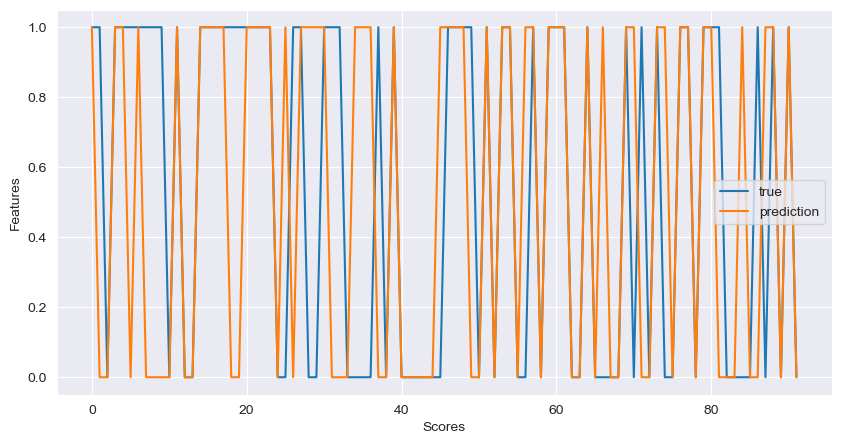

In [317]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics

knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='true')
plt.plot(y_pred,  label='prediction')
plt.xlabel('Scores')
plt.ylabel('Features')
plt.legend()

print("true values             \n", y_test)  # true values
print("predicted by sklearn kNN\n", y_pred)  # predicted values
print('classes:           %s' % np.unique(y_pred))
print('library precision: %s' % precision_score(y_test, y_pred, average=None))
print('library recall:    %s' % recall_score(y_test, y_pred, average=None))
print('accuracy score:    %s' % accuracy_score(y_test,y_pred))
print('confusion matrix:  \n%s' % confusion_matrix(y_test,y_pred))

cvsplt = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
for train_index, test_index in cvsplt.split(X_values, y_values):
    X_train, X_test = X_values[train_index], X_values[test_index]
    y_train, y_test = y_values[train_index], y_values[test_index]
    knn=KNeighborsClassifier(n_neighbors=10, metric='euclidean')
    knn.fit(X_train,y_train)
    y_pred=knn.predict(X_test)
    print(metrics.accuracy_score(y_test,y_pred))
    

true values              
 [1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0
 1 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1
 0 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0]
predicted by sklearn kNN 
 [0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0
 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 0]
predicted by my kNN      
 [1 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1
 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1
 1 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 0]
classes:           [0 1]
library precision: [0.94285714 0.84210526]
library recall:    [0.78571429 0.96      ]
accuracy score:    0.8804347826086957
confusion matrix:  
[[33  9]
 [ 2 48]]
0.6630434782608695
0.717391304347826
0.6521739130434783
0.717391304347826
0.75
0.7391304347826086
0.75
0.8043478260869565
0.6956521739130435
0.7065217391304348


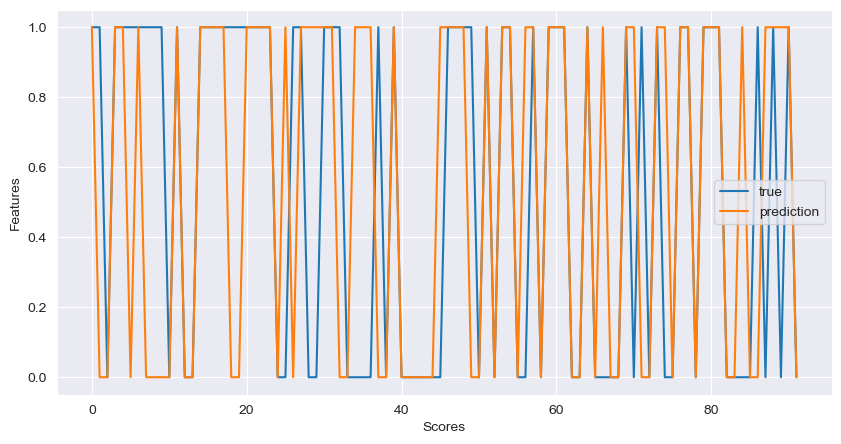

In [316]:
knn = MyKNearestNeighborsClassifier(10)
knn.fit(X_train, y_train)
my_y_pred = knn.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='true')
plt.plot(my_y_pred,  label='prediction')
plt.xlabel('Scores')
plt.ylabel('Features')
plt.legend()


print("true values              \n", y_test)  # true values
print("predicted by sklearn kNN \n", y_pred)  # predicted values
print("predicted by my kNN      \n", my_y_pred)  # predicted values

print('classes:           %s' % np.unique(y_pred))
print('library precision: %s' % precision_score(y_test, y_pred, average=None))
print('library recall:    %s' % recall_score(y_test, y_pred, average=None))
print('accuracy score:    %s' % accuracy_score(y_test,y_pred))
print('confusion matrix:  \n%s' % confusion_matrix(y_test,y_pred))

cvsplt = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
for train_index, test_index in cvsplt.split(X_values, y_values):
    X_train, X_test = X_values[train_index], X_values[test_index]
    y_train, y_test = y_values[train_index], y_values[test_index]
    knn=MyKNearestNeighborsClassifier(10)
    knn.fit(X_train,y_train)
    my_y_pred=knn.predict(X_test)
    print(metrics.accuracy_score(y_test,my_y_pred))

true values                
 [1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0
 1 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1
 0 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0]
predicted by decision tree 
 [0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0
 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 0]
classes:           [0 1]
library precision: [0.94285714 0.84210526]
library recall:    [0.78571429 0.96      ]
accuracy score:    0.8804347826086957
confusion matrix:  
[[33  9]
 [ 2 48]]
0.8260869565217391
0.8804347826086957
0.8369565217391305
0.8478260869565217
0.8478260869565217
0.8695652173913043
0.8586956521739131
0.8369565217391305
0.8369565217391305
0.8804347826086957


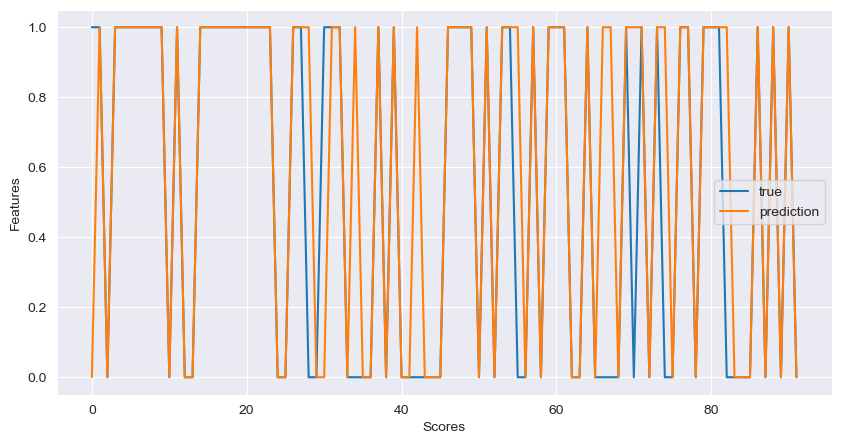

In [315]:
#define DT classifier, specificy a maximum tree depth of 3
dt = DecisionTreeClassifier(max_depth=3)
#define training and testing data, fit the classifier
dt.fit(X_train, y_train)
#predict values for test data based on training data
y_pred = dt.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='true')
plt.plot(y_pred,  label='prediction')
plt.xlabel('Scores')
plt.ylabel('Features')
plt.legend()

#print values
print("true values                \n", y_test)  # true values
print("predicted by decision tree \n", y_pred)  # predicted values

print('classes:           %s' % np.unique(y_pred))
print('library precision: %s' % precision_score(y_test, y_pred, average=None))
print('library recall:    %s' % recall_score(y_test, y_pred, average=None))
print('accuracy score:    %s' % accuracy_score(y_test,y_pred))
print('confusion matrix:  \n%s' % confusion_matrix(y_test,y_pred))

cvsplt = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
for train_index, test_index in cvsplt.split(X_values, y_values):
    X_train, X_test = X_values[train_index], X_values[test_index]
    y_train, y_test = y_values[train_index], y_values[test_index]
    dt = DecisionTreeClassifier(max_depth=3)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    print(metrics.accuracy_score(y_test,y_pred))
    